In [1]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей) (пример AIM practice 2)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации. 
# 4. Вывести результат

In [2]:
#1. ГЕНЕРАЦИЯ НАБОРА ДАННЫХ

In [3]:
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

In [4]:
import os
import random
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class SymbolSequenceGenerator:
    def __init__(self, data_path: str, train_size: float = 0.8, spacing: int = 30):
        self.data_path = data_path
        self.train_size = train_size
        self.spacing = spacing

    def create_sequence_image(self, length: int):
        sequence, images = self._generate_list_of_images(length)
        if not images:
            raise ValueError("No images were generated — check dataset path and structure.")

        total_width = sum(img.shape[1] for img in images) + self.spacing * (len(images) - 1)
        max_height = max(img.shape[0] for img in images) + 10

        # White background
        sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255

        x_offset = 0
        for img in images:
            h, w = img.shape
            y_offset = (max_height - h) // 2  # Center vertically
            sequence_img[y_offset:y_offset + h, x_offset:x_offset + w] = img
            x_offset += w + self.spacing

        return sequence, cv.bitwise_not(sequence_img)
    
    def _generate_list_of_images(self, length: int) -> list[str] | list:
        available_symbols = self._get_available_symbols(self.data_path)
        sequence = random.choices(available_symbols, k=length)
        sequence_normalized = [self._normalize_symbol_name(sym) for sym in sequence]
        print(f"Generating: {sequence_normalized}")

        images = []
        for char in sequence:
            img = self._get_random_symbol_image(char)
            if img is not None:
                images.append(img)
        
        return sequence_normalized, images

    def _get_random_symbol_image(self, folder_name: str):
        symbol_dir = os.path.join(self.data_path, folder_name)
        images = sorted(os.listdir(symbol_dir))
        start_idx = int(len(images) * self.train_size)
        subset = images[start_idx:]
        if not subset:
            subset = images

        random_image = random.choice(subset)
        img_path = os.path.join(symbol_dir, random_image)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Failed to read image: {img_path}")
            return None
    
        return img
    
    @staticmethod
    def _normalize_symbol_name(symbol: str) -> str:
        mapping = {'X': 'x', 'times': '*'}
        return mapping.get(symbol, symbol)
    
    @staticmethod
    def _get_available_symbols(data_path: str) -> list[str]:
        subfolders = [
            name for name in next(os.walk(data_path))[1]
            if not name.startswith('.')
        ]
        return subfolders

    @staticmethod
    def _display_single_char(img, folder_name, random_image):
        try:
            plt.figure(figsize=(1, 1))
            plt.imshow(cv.bitwise_not(img), cmap='gray')
            plt.axis('off')
            plt.title(f'Symbol: {folder_name} / {random_image}')
            plt.show()
        except Exception:
            pass

In [6]:
path_to_folder = './data'
generator = SymbolSequenceGenerator(path_to_folder)

In [7]:
def show_image(img: np.ndarray):
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Generating: ['+', '3', '9', '(', 'x', '7', '2', '1', '1', '6']


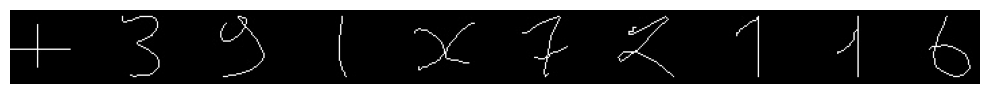

In [8]:
_, sequence_image = generator.create_sequence_image(10)
show_image(sequence_image)

In [9]:
# КЛАССИФИКАЦИЯ (k ближайших соседей) 

In [10]:
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [12]:
class DataLoader:
    def load_data(self, data_path: str, train_ratio: float = 0.8):
        X, Y = [], []
        symbols = self._get_available_symbols(data_path)
        print(f"Found symbols: {symbols}")

        for symbol in symbols:
            symbol_dir = os.path.join(data_path, symbol)
            images = sorted(os.listdir(symbol_dir))
            if not images:
                print(f"\tWarning: no images found for symbol '{symbol}'")
                continue

            label = self._normalize_symbol_name(symbol)
            for img_name in images:
                img_path = os.path.join(symbol_dir, img_name)
                img_vector = self._load_image(img_path)
                if img_vector is None:
                    print(f"\tWarning: failed to read image {img_path}")
                    continue
                X.append(img_vector)
                Y.append(label)

        X = np.array(X)
        Y = np.array(Y)
        print(f"Total images loaded: {len(X)}")

        # Split into train/test
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, train_size=train_ratio, stratify=Y, random_state=42
        )
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        
        return X_train, X_test, Y_train, Y_test
    
    @staticmethod
    def _get_available_symbols(data_path: str) -> list[str]:
        return [name for name in next(os.walk(data_path))[1] if not name.startswith('.')]

    @staticmethod
    def _normalize_symbol_name(symbol: str) -> str:
        mapping = {'X': 'x', 'times': '*'}
        return mapping.get(symbol, symbol)

    @staticmethod
    def _load_image(img_path: str):
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        if img is None:
            return None
        return img.flatten()

In [13]:
class ModelComparator:
    def __init__(self):
        self.model_results = {}
        
    def add_model_result(self, model_name: str, model: KNeighborsClassifier, accuracy: float):
        self.model_results[model_name] = {
            'model': model,
            'accuracy': accuracy
        }
        
    def compare_models(self):
        for name, result in sorted(self.model_results.items()):
            print(f"{name}: Accuracy = {result['accuracy']:.4f}")
        
        if self.model_results:
            best_name = max(self.model_results.keys(), 
                          key=lambda x: self.model_results[x]['accuracy'])
            best_result = self.model_results[best_name]
            return best_name, best_result['model'], best_result['accuracy']

        return None, None, None

In [14]:
data_loader = DataLoader()
X_train, X_test, Y_train, Y_test = data_loader.load_data("./data")

Found symbols: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', 'times', 'w', 'X', 'y']
Total images loaded: 225291
Train size: 180232, Test size: 45059


In [15]:
comparator = ModelComparator()

In [16]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, Y_train)
accuracy_knn1 = accuracy_score(Y_test, knn1.predict(X_test))
comparator.add_model_result("KNN-1", knn1, accuracy_knn1)
print(f"KNN-1 accuracy: {accuracy_knn1:.4f}")

KNN-1 accuracy: 0.9883


In [17]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, Y_train)
accuracy_knn3 = accuracy_score(Y_test, knn3.predict(X_test))
comparator.add_model_result("KNN-3", knn3, accuracy_knn3)
print(f"KNN-3 accuracy: {accuracy_knn3:.4f}")

KNN-3 accuracy: 0.9199


In [18]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, Y_train)
accuracy_knn5 = accuracy_score(Y_test, knn5.predict(X_test))
comparator.add_model_result("KNN-5", knn5, accuracy_knn5)
print(f"KNN-5 accuracy: {accuracy_knn5:.4f}")

KNN-5 accuracy: 0.7839


In [19]:
knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(X_train, Y_train)
accuracy_knn7 = accuracy_score(Y_test, knn7.predict(X_test))
comparator.add_model_result("KNN-7", knn7, accuracy_knn7)
print(f"KNN-7 accuracy: {accuracy_knn7:.4f}")

KNN-7 accuracy: 0.7374


In [20]:
best_name, best_knn_model, best_accuracy = comparator.compare_models()
print(f"Best model: {best_name} with accuracy {best_accuracy:.4f}")

KNN-1: Accuracy = 0.9883
KNN-3: Accuracy = 0.9199
KNN-5: Accuracy = 0.7839
KNN-7: Accuracy = 0.7374
Best model: KNN-1 with accuracy 0.9883


In [21]:
# РАСПОЗНАВАНИЕ

In [22]:
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации. 
# 4. Вывести результат

Generating: ['9', '3', '5', '+', '0', 'x', '7', '8', '7', '7']


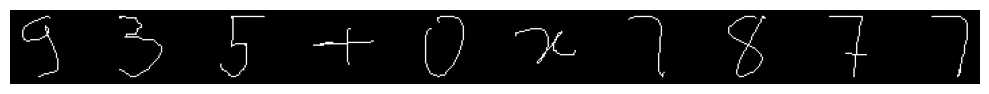

In [23]:
# 1. Генерация изображения с последовательностью символов
sequence, img_gray = generator.create_sequence_image(10)
image_rgb = cv.cvtColor(img_gray, cv.COLOR_GRAY2RGB)

show_image(img_gray)

Thresh shape: (55, 720, 3)


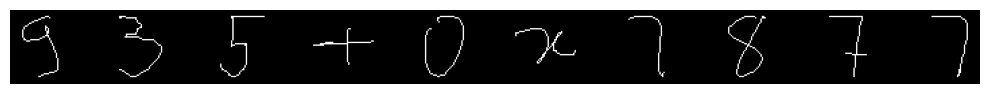

In [24]:
# 2. Выделение объектов оставляете как есть.
_, thresh = cv.threshold(image_rgb, 127, 255, 0)
print("Thresh shape:", thresh.shape)
thresh = np.uint8(thresh)

show_image(thresh)

In [25]:
contours, h = cv.findContours(thresh[:,:,0], cv.RETR_EXTERNAL, 2)

1: [9, 5, 27, 45]
2: [81, 5, 32, 45]
3: [156, 5, 33, 45]
4: [225, 14, 45, 27]
5: [308, 5, 29, 45]
6: [375, 14, 45, 26]
7: [459, 5, 27, 45]
8: [533, 5, 28, 45]
9: [608, 5, 28, 45]
10: [684, 5, 27, 45]


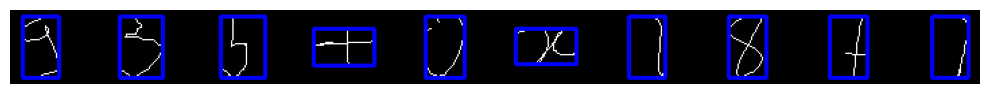

In [26]:
crops = []
for i in range(len(contours)):
    cnt = contours[i]
    area = cv.contourArea(cnt)
    x,y,w,h = cv.boundingRect(cnt)
    if w*h > 50:
        cv.rectangle(image_rgb,(x,y),(x+w,y+h),(0,0,255),2)
        ret,thresh = cv.threshold(img_gray[y:y+h, x:x+w],127,255,0)
        crops.append([x,y,w,h]) 
        
crops.sort(key=lambda x: x[0])

# Show crops
for idx, crop in enumerate(crops):
    print(f'{idx + 1}:', crop)

show_image(image_rgb)

In [27]:
def pad_to_size(img, target_size=(45, 45)):
    h, w = img.shape
    target_h, target_w = target_size
    
    padded = np.zeros(target_size, dtype=np.uint8)
    y_start = (target_h - h) // 2
    x_start = (target_w - w) // 2
    
    padded[y_start:y_start+h, x_start:x_start+w] = img
    return padded

def pad_and_crop(img, target_size=(45, 45), threshold=10):
    h, w = img.shape
    target_h, target_w = target_size
    
    if h == target_h and w == target_w:
        return img
    
    if h > target_h or w > target_w:
        # Обрезаем черные края
        non_zero_rows = np.where(np.max(img, axis=1) > threshold)[0]
        non_zero_cols = np.where(np.max(img, axis=0) > threshold)[0]
        
        if len(non_zero_rows) > 0 and len(non_zero_cols) > 0:
            y1, y2 = non_zero_rows[0], non_zero_rows[-1] + 1
            x1, x2 = non_zero_cols[0], non_zero_cols[-1] + 1
            img = img[y1:y2, x1:x2]
        
        # Масштабируем
        h, w = img.shape
        scale = min(target_h / h, target_w / w)
        if scale < 1.0:
            new_h, new_w = int(h * scale), int(w * scale)
            img = cv.resize(img, (new_w, new_h))
    
    return pad_to_size(img, target_size)

In [28]:
data_img = []
for i in range(len(crops)):
    x,y,w,h = crops[i]
    img = img_gray[y:y+h, x:x+w]

    base_size=img.shape[0]+2,img.shape[1]+30
    base=np.zeros(base_size,dtype=np.uint8)
    base[1:img.shape[0]+1,15:img.shape[1]+15]=img

    base_padded = pad_and_crop(base)
    data_img.append(base_padded)

In [29]:
# 3. Примернить k-nn для решения задачи классификации.
predictions = []
for idx, img in enumerate(data_img):
    img_vector = cv.bitwise_not(img).flatten()
    pred = best_knn_model.predict([img_vector])[0]
    predictions.append(pred)

In [30]:
# 4. Вывести результат
print(f"Predicted sequence: {' '.join(predictions)}")
print(f"Expected sequence: {' '.join(sequence)}")
print("Accuracy:", round(sum(1 for p, s in zip(predictions, sequence) if p == s) / len(sequence), 4))

Predicted sequence: 9 3 5 + 0 x 7 8 7 7
Expected sequence: 9 3 5 + 0 x 7 8 7 7
Accuracy: 1.0
